In [189]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.cluster import adjusted_rand_score
import scipy.io

In [2]:
def _euclidean_distance(X, Y, squared=False):
    XX = np.dot(X,X.T).diagonal()[:, np.newaxis]
    YY = np.dot(Y,Y.T).diagonal()[np.newaxis, :]
    distances = (-2 * np.dot(X,Y.T)) + XX + YY
    np.maximum(distances, 0, out=distances)
    if X is Y:
        np.fill_diagonal(distances, 0)
    return np.sqrt(distances, out=distances) if squared else distances

def _pairwise_kernel(X, Y = None, kernel = 'rbf', d=1):
    if Y is None:
        Y = X
    
    if kernel == 'linear':
        return np.dot(X, Y.T)
    elif kernel == 'rbf':
        dist = _euclidean_distance(X, Y, squared=True)
        # K *= -d
        return np.exp(-dist**2 / (2 * d**2))
        # return (np.exp(dist/(2*(d**2))))
    elif kernel.startswith('poly'):
        return (np.dot(X, Y.T)) ** d
    else:
        raise ValueError('Invalid kernel type.')

In [211]:
import numpy as np

def kernel_k_means(cluster_elem, K, dataset_weights, clusters, display=False):
    # Convergence threshold
    e = 0.0001

    # Initialize variables
    clustering_error = 0
    data_num = K.shape[0]
    center_dist = np.zeros(data_num)
    iter = 1

    while True:
        old_clustering_error = clustering_error
        clustering_error = 0
        
        intra = np.zeros(clusters)
        cluster_dist = np.zeros((data_num, clusters))

        for i in range(clusters):
            this_elem = np.where(cluster_elem == i)[0]
            dataset_weights_this_elem = dataset_weights[this_elem]
            
            intra[i] = np.dot(dataset_weights_this_elem, 
                np.dot(K[np.ix_(this_elem, this_elem)], dataset_weights_this_elem))
            intra[i] /= np.sum(dataset_weights_this_elem) ** 2
            
            cluster_dist[:,i] = np.dot(K[:,this_elem], dataset_weights_this_elem)
            
            cluster_dist[:,i] = (-2 * cluster_dist[:,i] / np.sum(dataset_weights_this_elem)) + intra[i] + np.diag(K)
                        
            clustering_error += np.dot(dataset_weights_this_elem, cluster_dist[this_elem, i])

        min_dist, new_cluster_elem = np.min(cluster_dist, axis=1), np.argmin(cluster_dist, axis=1)
        
        if display:
            print(f'\nKernel K-Means Iteration {iter}') 
            print(f'Clustering error={clustering_error}')

        if iter > 1:
            if abs(old_clustering_error) < 10**(-10) or abs(1 - (clustering_error/old_clustering_error)) < e:
                break

        cluster_elem = new_cluster_elem
        
        # Handle empty clusters
        count = 0
        for i in range(clusters):
            if np.sum(new_cluster_elem == i) == 0:
                tmp = np.where(new_cluster_elem > i)[0]
                cluster_elem[tmp] -= 1
                count += 1
                print('Dropping empty cluster')
        
        clusters -= count

        iter += 1
    
    return cluster_elem, clustering_error, center_dist

In [ ]:
def kernel_k_means2(clusters, kernel, weights, n_clusters, display=False):
  tolerance = 0.0001
  error = 0
  n = kernel.shape[0]
  center_dists = np.zeros(n)
  iter_num = 1
  
  all_errs = []
  while True:
    old_error = error
    error = 0
    
    intra_cluster = np.zeros(n_clusters)
    center_dists = np.zeros((n, n_clusters))

    for i in range(n_clusters):

      cluster_points = np.where(clusters == i)[0]
      cluster_weights = weights[cluster_points]

      intra_cluster[i] = np.dot(np.dot(kernel[cluster_points, :][:, cluster_points], 
                                       cluster_weights), cluster_weights)
      # intra_cluster[i] /= np.sum(cluster_weights) ** 2
      intra_cluster[i] /= (np.sum(cluster_weights) ** 2 + 1e-10)

      center_dists[:,i] = np.dot(kernel[:, cluster_points], cluster_weights) 
      # center_dists[:,i] = -2 * center_dists[:,i] / np.sum(cluster_weights) + intra_cluster[i]
      center_dists[:,i] = -2 * center_dists[:,i] / (np.sum(cluster_weights) + 1e-10) + intra_cluster[i]
      center_dists[:,i] += np.diag(kernel)

      error += np.dot(cluster_weights, center_dists[cluster_points, i])
      

    min_dists, clusters = np.min(center_dists, axis=1), np.argmin(center_dists, axis=1)
    
    if display:
      print(f'Iteration {iter_num}: Error = {error}')

    # if iter_num > 1 and abs(1 - (error / old_error)) < tolerance:
    all_errs.append(error)
    #  or (iter_num > 4 and len(set(all_errs[-4:])) < 3)
    if (iter_num > 1 and abs(1 - (error / (old_error + 1e-10))) < tolerance) or (iter_num > 4 and len(set(all_errs[-4:])) < 3):
      break

    iter_num += 1
      
  return clusters, error, center_dists

In [262]:
def CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights):
  if p < 1:
    raise ValueError('p must be greater than or equal to 1')

  if np.any(init_weights < 0) or abs(np.sum(init_weights) - 1) > 1e-15:
    raise ValueError('Weights must be positive and sum to unity')

  n_points = K.shape[0] // n_views

  iter_num = 1
  old_error = np.inf

  clusters = init_clusters
  weights = init_weights

  trace_per_cluster_view = [[] for _ in range(n_clusters)]
  for i in range(n_views):
    K_view = K[i*n_points:(i+1)*n_points, :]  
    for j in range(n_clusters):
      cluster_points = np.where(clusters == j)[0]
      K_cluster = K_view[cluster_points[:, None], cluster_points]
      trace_per_cluster_view[j].append(np.trace(K_cluster))
  trace_per_cluster_view = np.array(trace_per_cluster_view)
  # trace_per_view = [np.trace(K[i*n_points:(i+1)*n_points, :]) for i in range(n_views)]

  while True:
    print('--------------- CWK2M Iteration {} ---------------'.format(iter_num))

    # Update clusters
    print('Updating clusters...')

    # K_combined = np.zeros((n_points, n_points))
    # for i in range(n_views):
    #   for k in range(n_clusters):
    #     K_combined += weights[i, k]**p * K[i*n_points:(i+1)*n_points, :]

    K_combined = np.zeros((n_points, n_points))
    for i in range(n_views):
      start = i * n_points
      end = (i+1) * n_points
      K_ = K[start:end, :].copy()
      for k in range(n_clusters):
        K_combined[np.where(clusters == k)[0], :] += weights[i, k]**p * K_[np.where(clusters == k)[0], :]
        K_combined[:, np.where(clusters == k)[0]] += weights[i, k]**p * K_[:, np.where(clusters == k)[0]]

    clusters, error, _ = kernel_k_means(clusters, K_combined, np.ones(n_points), n_clusters) 
    print('Objective after updating clusters:', error)

    if len(np.unique(clusters)) < n_clusters:
      raise ValueError('Empty clusters detected')

    # Y = csr_matrix((n_points, n_clusters))
    Y = lil_matrix((n_points, n_clusters))
    for i in range(n_clusters):
      cluster_points = np.where(clusters == i)[0]
      Y[cluster_points, i] = 1 / np.sqrt(len(cluster_points) + 1e-10)

    trace_per_cluster_view_new = []
    for i in range(n_clusters):
      cluster_traces = []
      cluster_points = np.where(clusters == i)[0]
      Y_cluster = Y[cluster_points, i]  
      for j in range(n_views):
        K_view = K[j*n_points:(j+1)*n_points, :]
        K_cluster = K_view[cluster_points[:, None], cluster_points]
        trace_cluster = np.trace(Y_cluster.T @ K_cluster @ Y_cluster)
        cluster_traces.append(trace_cluster)
      trace_per_cluster_view_new.append(cluster_traces)
    trace_per_cluster_view_new = np.array(trace_per_cluster_view_new)
    # trace_per_view_new = [np.trace(Y.T @ K[i*n_points:(i+1)*n_points, :] @ Y) for i in range(n_views)]

    trace_diff = abs(np.array([a - b for a, b in zip(trace_per_cluster_view, trace_per_cluster_view_new)])).T
    # trace_diff = np.array([a - b for a, b in zip(trace_per_view, trace_per_view_new)])

    if abs(1 - (error / old_error)) < 0.0001 or error < 1e-6:
      print('CWK2M reached convergence')
      break

    old_error = error

    # Update weights 
    print('Updating weights...')

    if p != 1:
      # weights = 1 / np.power(trace_diff, 1/(p-1))
      # weights /= np.sum(weights)
      weights = 1/(trace_diff**(1/(p-1)) * np.sum(1/(trace_diff**(1/(p-1)))))
      # print(weights)
    else:
      min_idx = np.argmin(trace_diff)
      weights = np.zeros(n_views)
      weights[min_idx] = 1

    weights[weights < 1e-5] = 0 
    weights /= np.sum(weights)
    
    # print('Objective after updating weights:', (weights**p) @ trace_diff)
    # print('Objective after updating weights:', np.sum((weights**p) @ trace_diff.T))
    print()

    iter_num += 1

  return clusters, weights, error

In [ ]:
def global_kernel_k_means(kernel, weights, n_clusters, display=False):
  n = kernel.shape[0]
  
  best_errors = np.inf * np.ones(n_clusters)
  best_clusters = np.ones((n, n_clusters))

  # Find 1 cluster solution
  best_clusters[:,0], best_errors[0], _ = kernel_k_means(best_clusters[:,0], kernel, weights, 1, display)

  for m in range(2, n_clusters+1):

    for i in range(n):
    
      clusters = best_clusters[:,m-1].copy()
      clusters[i] = m
      
      if display:
        print(f"\nSearching for {m} clusters. Placing {m}th cluster at point {i} initially.")

      clusters, error, _ = kernel_k_means(clusters, kernel, weights, m, display)

      if display:
        print(f"Final error: {error}")

      if best_errors[m-1] > error:
        best_errors[m-1] = error
        best_clusters[:,m-1] = clusters

  if np.unique(best_clusters[:,m-1]).size < m:
    raise ValueError(f"Could not find more than {m-1} clusters")

  best_idx = np.argmin(best_errors)
  clusters = best_clusters[:, best_idx]
  error = best_errors[best_idx]

  if display:
    print(f"\nBest solution: {best_idx+1} clusters with error {error}")

  return clusters, error

In [550]:
import numpy as np


def fast_global_kernel_k_means(K, dataset_weights, total_clusters, display=False):
    # Dataset size
    data_num = K.shape[0]
    
    # Store optimal clustering error for 1,2,...,total_clusters clusters
    best_error = np.zeros(total_clusters)
    
    # Store cluster assignments for optimal 1,2,...,total_clusters clusters 
    best_clusters = np.ones((data_num, total_clusters), dtype=int)
    
    # Find 1 cluster solution
    best_clusters[:,0], best_error[0], center_dist = kernel_k_means(best_clusters[:,0], K, dataset_weights, 1, display)
    
    # Find 2,...,total_clusters solutions
    for m in range(2, total_clusters):
        max_reduction = -1
        
        # Place m-th cluster at point n, calculate guaranteed error reduction
        for n in range(data_num):
            reduction = center_dist - (K[n,n] + np.diag(K) - 2*K[n,:])
            reduction[reduction < 0] = 0
            total_reduction = np.dot(dataset_weights, reduction)

            if (total_reduction > max_reduction).all():
                max_reduction = total_reduction
                index = n
        
        # Initialize m-th cluster at point with max error reduction
        cluster_elem = best_clusters[:,m-1].copy() 
        cluster_elem[index] = m
        
        if display == 'details' or display == 'nutshell':
            print('\n\nSearching for {} clusters. Initially placing {}th cluster at point {}'.format(m, m, index))
            
        # Find m cluster solution 
        best_clusters[:,m], best_error[m], center_dist = kernel_k_means(cluster_elem, K, dataset_weights, m, display)
        center_dist = center_dist[:,m-1]
        
        if display == 'details' or display == 'nutshell':
            print('Final Clustering error={}'.format(best_error[m]))
            
        if len(np.unique(best_clusters[:,m])) < m:
            raise Exception('Not able to find more than {} clusters'.format(m-1))
            
    # Solution with lowest error is best
    min_error_idx = np.argmin(best_error)
    clustering_error = best_error[min_error_idx]
    cluster_elem = best_clusters[:, min_error_idx]
    
    if display == 'details' or display == 'nutshell':
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print('Best fit: {} clusters with Clustering Error={}'.format(min_error_idx+1, clustering_error))
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
    return cluster_elem, clustering_error

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 112.36171813018049
Updating weights...

--------------- CWK2M Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 78.01136327616922
Updating weights...

--------------- CWK2M Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 72.51816995418162
Updating weights...

--------------- CWK2M Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 59.539190895598864
Updating weights...

--------------- CWK2M Iteration 5 ---------------
Updating clusters...
Objective after updating clusters: 43.36722442192131
Updating weights...

--------------- CWK2M Iteration 6 ---------------
Updating clusters...
Objective after updating clusters: 43.36722442192131
CWK2M reached convergence


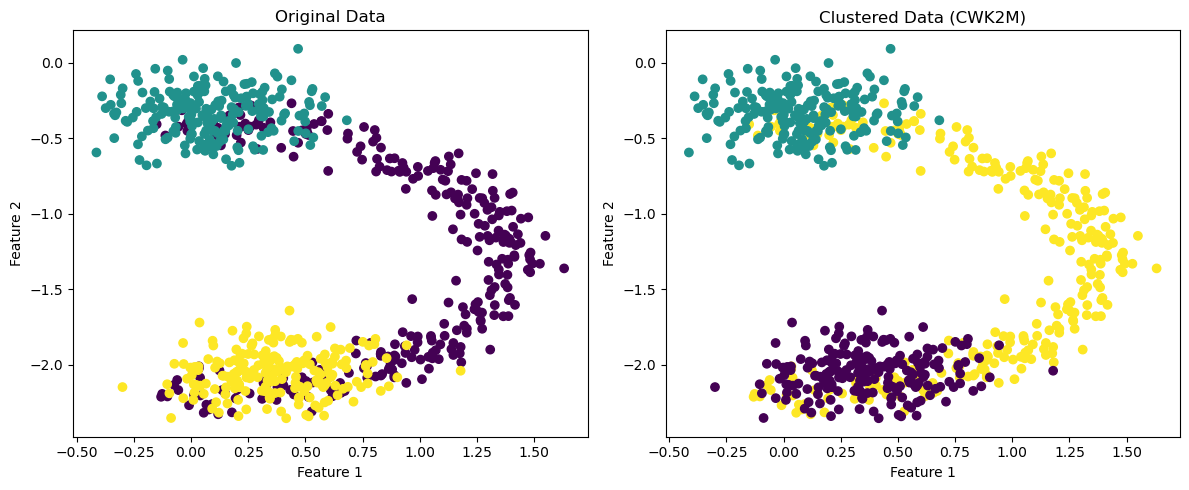

In [265]:
n_clusters = 3
data = scipy.io.loadmat('datasets/synthetic_data.mat')

X1 = data["View_1"]
X2 = data["View_2"]
X = [X1, X2]
y = data["Ground_truth"]

# K = np.array(scipy.io.loadmat('datasets/synthetic_data_kernel.mat')['K'])
K = np.vstack([_pairwise_kernel(X1, kernel="rbf", d=0.25), _pairwise_kernel(X2, kernel="rbf", d=0.25)])

# Run CWK2M
n_views = 2
p = 1.5
init_weights = np.full((n_views, n_clusters), 1 / (n_views * n_clusters))
n_points = K.shape[0] // n_views
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
# K_combined = np.zeros((n_points, n_points))
# for i in range(n_views):
#   start = i * n_points
#   end = (i+1) * n_points
#   K_ = K[start:end, :]
#   for k in range(n_clusters):
#     K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
#     K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]
    
# best=0
# for i in range(100):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('synthetic_init.npy', init_clusters)
#     if nmi_score == 100: break

# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
init_clusters = np.load('synthetic_init.npy')

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

# Plot the original data and the clustered data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X2[:, 0], X2[:, 1], c=y, cmap='viridis')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustered Data (CWK2M)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [266]:
from sklearn.metrics import normalized_mutual_info_score

# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 100.0 %


In [219]:
# Calculate َARI
ari_score = adjusted_rand_score(cluster_labels, y.flatten())
print("Adjusted Rand Index (ARI):", np.round(ari_score * 100, 2), "%")

Adjusted Rand Index (ARI): 100.0 %


### Multiple Features dataset

In [270]:
import pandas as pd

# V1 = pd.read_csv('datasets/HW/mfeat-fou', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V2 = pd.read_csv('datasets/HW/mfeat-fac', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V3 = pd.read_csv('datasets/HW/mfeat-kar', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V4 = pd.read_csv('datasets/HW/mfeat-pix', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# X = [V1, V2, V3, V4]
# y = np.vstack([np.full(200, i) for i in range(10)]).flatten()

data = scipy.io.loadmat('datasets/handwritten.mat')
X_ = data['X'].flatten()
X = [X_[0].astype(np.float64), X_[1].astype(np.float64), X_[2].astype(np.float64), X_[3].astype(np.float64)]
y = data['Y'].flatten()

n_clusters = 10
K = np.vstack([_pairwise_kernel(v, kernel="linear", d=2)/np.mean(_pairwise_kernel(v, kernel="linear", d=2)) for v in X])

# Run CWK2M
n_points = K.shape[0] // n_views
n_views = len(X)
p = 1.5
init_weights = np.full((n_views, n_clusters), 1 / (n_views * n_clusters))
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
# K_combined = np.zeros((n_points, n_points))
# for i in range(n_views):
#   start = i * n_points
#   end = (i+1) * n_points
#   K_ = K[start:end, :]
#   for k in range(n_clusters):
#     K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
#     K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]

# best=0
# for i in range(25):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('hw_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
# init_clusters = np.load('hw_init.npy')
init_clusters = np.random.randint(0, n_clusters, n_points)

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 9.360201135295231
Updating weights...

--------------- CWK2M Iteration 2 ---------------
Updating clusters...


KeyboardInterrupt: 

In [254]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score, 2))

Normalized Mutual Information (NMI): 0.63


In [255]:
# Calculate َARI
ari_score = adjusted_rand_score(cluster_labels, y.flatten())
print("Adjusted Rand Index (ARI):", np.round(ari_score, 2))

Adjusted Rand Index (ARI): 0.45


### MSRC-v1

In [201]:
data = scipy.io.loadmat('datasets/MSRC-v1.mat')

X = data["X"].flatten()
# X = np.array([v.astype(np.float64) or v in X])
X = [np.array(v, dtype=np.float64) for v in X]
y = data["Y"]

n_clusters = 7
K = np.vstack([_pairwise_kernel(v, kernel="rbf", d=0.5)/np.mean(_pairwise_kernel(v, kernel="rbf", d=0.5)) for v in X])

# Run CWK2M
n_points = K.shape[0] // n_views
n_views = len(X)
p = (10**0.7)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_ = K[start:end, :]
  for k in range(n_clusters):
    K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
    K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]

# best=0
# for i in range(50):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('msrcv_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
init_clusters = np.load('msrcv_init.npy')

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 246.51992816650755
Updating weights...

--------------- CWK2M Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 0.00293391013022568
Updating weights...

--------------- CWK2M Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 0.002961056401244603
Updating weights...

--------------- CWK2M Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 0.002870709413860807
Updating weights...

--------------- CWK2M Iteration 5 ---------------
Updating clusters...
Objective after updating clusters: 0.0028922901745135755
Updating weights...

--------------- CWK2M Iteration 6 ---------------
Updating clusters...
Objective after updating clusters: 0.002869123557906748
Updating weights...

--------------- CWK2M Iteration 7 ---------------
Updatin

In [202]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 68.48 %


In [203]:
# Calculate َARI
ari_score = adjusted_rand_score(cluster_labels, y.flatten())
print("Adjusted Rand Index (ARI):", np.round(ari_score * 100, 2), "%")

Adjusted Rand Index (ARI): 59.4 %


### Caltech101-7

In [117]:
data = scipy.io.loadmat('datasets/Caltech101-7.mat')
X_ = data['X'].flatten()
X = [X_[0].astype(np.float64), X_[1].astype(np.float64), X_[2].astype(np.float64), X_[3].astype(np.float64)]
y = data['Y'].flatten()

n_clusters = len(np.unique(y))
K = np.vstack([_pairwise_kernel(v, kernel="poly", d=0.5)/np.mean(_pairwise_kernel(v, kernel="poly", d=0.5)) for v in X])

# Run CWK2M
n_points = K.shape[0] // n_views
n_views = len(X)
p = (10**0.9)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_ = K[start:end, :]
  for k in range(n_clusters):
    K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
    K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]

# best=0
# for i in range(50):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('caltech101_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
# init_clusters = np.load('caltech101_init.npy')
init_clusters = np.random.randint(0, n_clusters, n_points)

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
5
[0.021692418645948022]
1
Objective after updating clusters: 0.013053602579199044
Updating weights...

--------------- CWK2M Iteration 2 ---------------
Updating clusters...
5
[4.318836856495906e-09]
1
Objective after updating clusters: 4.356813044355771e-09
CWK2M reached convergence


In [118]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 31.51 %


### Reuters

In [5]:
data = scipy.io.loadmat('datasets/reuters.mat')
X_ = data['X'].flatten()
X = [x.astype(np.float64) for x in X_]
y = data['Y'].flatten()

n_clusters = len(np.unique(y))
K = np.vstack([_pairwise_kernel(v, kernel="rbf", d=0.5)/np.mean(_pairwise_kernel(v, kernel="rbf", d=0.5)) for v in X])

# Run CWK2M
n_points = K.shape[0] // n_views
n_views = len(X)
p = (10**0.9)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
# K_combined = np.zeros((n_points, n_points))
# for i in range(n_views):
#   start = i * n_points
#   end = (i+1) * n_points
#   K_ = K[start:end, :]
#   for k in range(n_clusters):
#     K_combined[np.where(init_clusters == k)[0], :] += init_weights[i, k]**p * K_[np.where(init_clusters == k)[0], :]
#     K_combined[:, np.where(init_clusters == k)[0]] += init_weights[i, k]**p * K_[:, np.where(init_clusters == k)[0]]

# best=0
# for i in range(50):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('caltech101_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
# init_clusters = np.load('caltech101_init.npy')
init_clusters = np.random.randint(0, n_clusters, n_points)

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

In [ ]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")